# ImgLib2 

Example 08: Working with sparse data

## Introduction

ImgLib2 supports sparsely sampled data, i.e. collections of locations together with their value. Such datasets typically implement the [IterableRealInterval](http://javadoc.imagej.net/ImgLib2/net/imglib2/IterableRealInterval.html) interface, which means they can be iterated and have real-valued locations in n-dimensional space. Currently ImgLib2 supports to store such collections either as list ([RealPointSampleList](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealPointSampleList.html)) or [KDTree](http://javadoc.imagej.net/ImgLib2/net/imglib2/KDTree.html). The [RealPointSampleList](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealPointSampleList.html) can be iterated, whereas the [KDTree](http://javadoc.imagej.net/ImgLib2/net/imglib2/KDTree.html) additionally supports three efficient ways of searching for nearest neighboring points in the n-dimensional space ([NearestNeighborSearch](http://javadoc.imagej.net/ImgLib2/net/imglib2/neighborsearch/NearestNeighborSearch.html), [KNearestNeighborSearch](http://javadoc.imagej.net/ImgLib2/net/imglib2/neighborsearch/KNearestNeighborSearch.html), and [RadiusNeighborSearch](http://javadoc.imagej.net/ImgLib2/net/imglib2/neighborsearch/RadiusNeighborSearch.html)).

In order to display sparse data ImgLib2 currently supports two interpolation schemes, the [NearestNeighborInterpolation](http://javadoc.imagej.net/ImgLib2/net/imglib2/interpolation/randomaccess/NearestNeighborInterpolator.html) and the [InverseDistanceWeightingInterpolation](http://javadoc.imagej.net/ImgLib2/net/imglib2/interpolation/neighborsearch/InverseDistanceWeightingInterpolator.html). They can compute a value for every location in space by returning either the value of the closest sample or an interpolated, distance-weighted value of the k nearest neighbors to the sampled location. The interpolation scheme therefore converts any [IterableRealInterval](http://javadoc.imagej.net/ImgLib2/net/imglib2/IterableRealInterval.html) into a [RealRandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealRandomAccessible.html) that can be displayed by wrapping it into a [RandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessible.html) and defining [Interval](http://javadoc.imagej.net/ImgLib2/net/imglib2/Interval.html) using [Views](http://javadoc.imagej.net/ImgLib2/net/imglib2/view/Views.html).

*This is, however, not only useful for display. Note that you execute on such data any algorithm or method that is implemented for [RealRandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealRandomAccessible.html) or [RandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessible.html), like Gaussian convolution in the first example. **Note that none of these ever exists in memory, it is done completely virtual on just the sparse samples.***

## Example 8a - Create random sparse data, display and convolve it

In this example we create a certain number of random samples with random intensities inside a certain [Interval](http://javadoc.imagej.net/ImgLib2/net/imglib2/Interval.html). Using nearest neighbor interpolation we wrap it into a [RealRandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RealRandomAccessible.html), wrap it again into a [RandomAccessible](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessible.html), define an [Interval](http://javadoc.imagej.net/ImgLib2/net/imglib2/Interval.html) on it and display it. On the same virtual data we perform a Gaussian convolution and show it, too.

Below is the utility method for a given interval magnification.

In [1]:
import net.imglib2.RealInterval
import net.imglib2.RealPointSampleList
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.RealPoint

obj = new Object() {
  /**
   * Create a number of n-dimensional random points in a certain interval
   * having a random intensity 0...1
   *
   * @param interval - the interval in which points are created
   * @param numPoints - the amount of points
   *
   * @return a RealPointSampleList (which is an IterableRealInterval)
   */
  public RealPointSampleList<FloatType> createRandomPoints(RealInterval interval, int numPoints) {
    // the number of dimensions
    numDimensions = interval.numDimensions()
    
    // a random number generator
    Random rnd = new Random(System.currentTimeMillis())
    
    // a list of Samples with coordinates
    RealPointSampleList<FloatType> elements = new RealPointSampleList<FloatType>(numDimensions)
    
    for (int i = 0; i < numPoints; ++i) {
      RealPoint point = new RealPoint(numDimensions)
      
      for (int d = 0; d < numDimensions; ++d) {
        point.setPosition( rnd.nextDouble() * (interval.realMax(d) - interval.realMin(d)) + interval.realMin(d), d )
        
        // add a new element with a random intensity in the range 0...1
        elements.add(point, new FloatType(rnd.nextFloat()))
      }
    }
    return elements
  }
}

Script1​$1​@15bf0fc2

At first it shows nearest-neighbor rendered random sparse data.

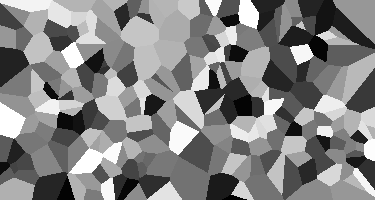

In [2]:
import net.imglib2.FinalInterval
import net.imglib2.IterableRealInterval
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.neighborsearch.NearestNeighborSearch
import net.imglib2.neighborsearch.NearestNeighborSearchOnKDTree
import net.imglib2.KDTree
import net.imglib2.interpolation.neighborsearch.NearestNeighborSearchInterpolatorFactory
import net.imglib2.view.Views

long[] range = [375, 200]
// the interval in which to create random points
interval = new FinalInterval(range)

// create an IterableRealInterval
 IterableRealInterval<FloatType> realInterval = obj.createRandomPoints(interval, 250)

// using nearest neighbor search we will be able to return a value an any position in space
search = new NearestNeighborSearchOnKDTree<FloatType>(new KDTree<FloatType>(realInterval))

// make it into RealRandomAccessible using nearest neighbor search
realRandomAccessible = Views.interpolate(search, new NearestNeighborSearchInterpolatorFactory<FloatType>())

// convert it into a RandomAccessible which can be displayed
randomAccessible = Views.raster(realRandomAccessible)

// set the initial interval as area to view
view = Views.interval(randomAccessible, interval)

At second it shows the result of a Gaussian convolution, run directly on the virtual [RandomAccessibleInterval](http://javadoc.imagej.net/ImgLib2/net/imglib2/RandomAccessibleInterval.html).

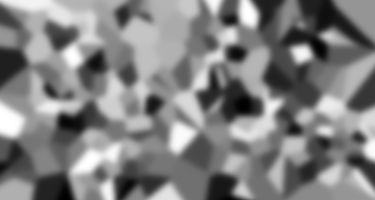

In [3]:
import net.imglib2.img.array.ArrayImgFactory
import net.imglib2.type.numeric.real.FloatType
import net.imglib2.algorithm.gauss.Gauss
import net.imglib2.Point

// compute a gauss on it
convolved = new ArrayImgFactory<FloatType>().create(interval, new FloatType())

double[] size = [3, 3]

Gauss.inFloat(size, view, interval, convolved, new Point(view.numDimensions() ), convolved.factory())

// display the convolved view
convolved